# How to use fastai tabular with custom metric

## How to easily train a tabular model with fastai

First, we have to load our data (I used the kaggle API to do this, check out my previous [blogpost](https://lschmiddey.github.io/fastpages_/2020/09/15/get-kaggle-api-started.html))

In [1]:
from pathlib import Path
p = Path('/notebooks/storage/data/Titanic')
filename = Path('/notebooks/storage/data/Titanic/titanic.zip')

In [ ]:
!unzip -q {str(filename)} -d {str(p/"train")}

### Get imports

In [2]:
import pandas as pd
from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype
from fastai.tabular.all import *
from sklearn.metrics import confusion_matrix

In [3]:
df = pd.read_csv(f'{p}/train/train.csv', index_col=0)
df.tail(5)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.00,NaN,S
888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.00,B42,S
889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.45,NaN,S
890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.00,C148,C
891,0,3,"Dooley, Mr. Patrick",male,32.0,0,0,370376,7.75,NaN,Q


In [4]:
df.shape

(891, 11)

Let's check out the data type for each column.

In [5]:
df.dtypes

Survived      int64
Pclass        int64
Name         object
Sex          object
Age         float64
SibSp         int64
Parch         int64
Ticket       object
Fare        float64
Cabin        object
Embarked     object
dtype: object

We see that "Pclass", "Sex", "Cabin" and "Embarked" are objects. When we think about these variables, they clearly are categorical variables. So let's change that.

In [6]:
df['Pclass'] =  df['Pclass'].astype('category')
df['Sex'] =  df['Sex'].astype('category')
df['Cabin'] =  df['Cabin'].astype('category')
df['Embarked'] =  df['Embarked'].astype('category')

I want to build a validation set, based on the index. The easiest way is to create an array with the length of our data, randomly select a percentage of indeces we want in our training data, and use the leftover indeces for our validation set.

In [7]:
# Define percentage of train data, define length of training indeces and validation indeces
p = 0.9
len_df = len(df)
len_idx_tain = round(len_df*p)
len_idx_val = len_df-len_idx_tain

In [8]:
# build array of indeces for training and validation
idx_arr = range(0,len_df)
train_idx = np.random.choice(range(0,len_df), len_idx_tain, replace=False)
val_idx = [i for i in idx_arr if i not in train_idx]
val_idx = np.asarray(val_idx)

Let's put these arrays into a split variable, which fastai knows how to make use of to split the data into training data and validation data.

In [9]:
splits = (list(train_idx),list(val_idx))

Then we make use of the "cont_cat_split" function to easily get a list of column names for each categorical and continuous variable.

In [10]:
cont_nn, cat_nn = cont_cat_split(df, dep_var='Survived')

In [11]:
cont_nn, cat_nn

(['Age', 'Fare'],
 ['Pclass', 'Name', 'Sex', 'SibSp', 'Parch', 'Ticket', 'Cabin', 'Embarked'])

That looks great! How about our missing values?

In [12]:
df.isna().sum()

Survived      0
Pclass        0
Name          0
Sex           0
Age         177
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       687
Embarked      2
dtype: int64

Looks like there are quite a few missing values for age and cabin. But we know a way to make use of that! Even "no-information" can be an information.

In [13]:
procs_nn = [Categorify, FillMissing, Normalize]

Fastai provides us with many super useful out-of-the-box functions. Three of them you can see here: Categorify will take all of the variables with type "category" will replace the category with a numerical number and write the mapping into a dictionary. FillMissing, well, does exactly this. It also provides us with a extra boolean variable, indicating whether the row has a missing value for a specific variable (e.g. age). Normalize then normalizes our continuous data and saves the standardzier.

In [14]:
df['Survived'] = df['Survived'].astype(np.float32)

This one is important: fastai needs the dependend variable to be of type float32, even though we have a binary classification! We need this, because the loss function will be mse-loss. This leads to possibly odd behavior: the numbers can get below 0 and even below -1 or above 2! If we use a provided metric like accuracy, this leads to odd results. So we will write our own custom metric! But first, let's use the TabularPandas class and put that in a dataloader (important: do not let the batchsize become bigger than your data, this will result in a error!).

In [15]:
to_nn = TabularPandas(df, procs_nn, cat_nn, cont_nn, splits=splits, y_names='Survived')
# length of data is 891, so let the batchsize be smaller than that!
dls = to_nn.dataloaders(256)

### Train Model

Now is the time to train our model. But wait! We first have to define a custom metric, because the accuracy provided by fastai will lead to odd results. I can show you what I mean:

In [23]:
learn = tabular_learner(dls, layers=[64, 8], n_out=1, metrics=[accuracy])

In [24]:
learn.fit_one_cycle(4,1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.336898,0.462910,0.584270,00:00
1,0.261536,0.425619,0.584270,00:00
2,0.195133,0.385734,0.584270,00:00
3,0.153365,0.351687,0.584270,00:00


What is going on here? Is the accuracy not improving? The answer is no. Tabular_learner in combination with accuracy does not give us the result we want. Why is that? First, our predictions will not be 0 or 1, but floating point values. That's good for our loss, so our model can learn from its gradient (checkout my blogpost about [gradients](https://lschmiddey.github.io/fastpages_/2020/09/01/Gradient-Descent.html) if you do not know what that means). But this leads to a malfunctioning of the accuracy metric, which fastai uses from sklearn. What we need to do is to define our own custom metric. Let's do that!

In [25]:
import sklearn.metrics as skm
 
def _accumulate(self, learn):
    m = nn.Sigmoid()
    pred = learn.pred
    pred = torch.round(m(pred))
    targ = learn.y
    pred,targ = to_detach(pred),to_detach(targ)
    self.preds.append(pred)
    self.targs.append(targ)

AccumMetric.accumulate = _accumulate

def BinAccu():
    return skm_to_fastai(skm.accuracy_score)

So what's going on here? Next to Callbacks, fastai provides a clever way how to customize metrics. To be honest, it took me some time to figure it out, but here's how it works. Each learner has a .pred and a .y, which means this is how you can get its predictions and its targets. As I already mentioned, preds are floating point values, but we want them to be between 0 and 1 - luckily, this is exactly what the sigmoid function is doing. Then we want the values to be either 0 or 1, so let's just round these values (threshold here is .5, but you can fiddle around with that). We then append these "new" preds and targets. 

"In order to provide a more flexible foundation to support metrics like this fastai provides a Metric abstract class which defines three methods: reset, accumulate, and value (which is a property). Reset is called at the start of training, accumulate is called after each batch, and then finally value is called to calculate the final check."

So with this function we directly sit on top of accumulate. The function skm_to_fastai let's you use sklearn metrics (in this case: accuracy_score) and uses the pred and targ we provided in our tiny function. Important: we have to instanciate the instance first!

In [84]:
binaccu = BinAccu()
learn = tabular_learner(dls, layers=[128, 8, 128], n_out=1, metrics=[binaccu])

Ok, we're good to go. Let's use fastai's awesome lr_find().

SuggestedLRs(lr_min=0.04365158379077912, lr_steep=0.001737800776027143)

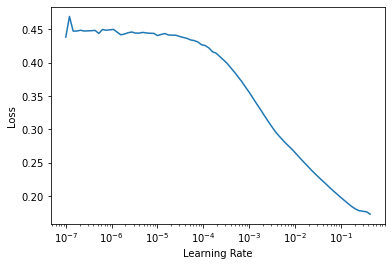

In [81]:
learn.lr_find()

Looks like we should set our learning rate to about 1e-3.

In [85]:
learn.fit_one_cycle(10,1e-3)

epoch,train_loss,valid_loss,accuracy_score,time
0,0.408988,0.484313,0.584270,00:00
1,0.354359,0.457268,0.584270,00:00
2,0.275204,0.412495,0.516854,00:00
3,0.213265,0.358083,0.415730,00:00
4,0.170837,0.307841,0.415730,00:00
5,0.140746,0.273276,0.415730,00:00
6,0.118833,0.252393,0.415730,00:00
7,0.102209,0.241727,0.415730,00:00
8,0.089564,0.236333,0.415730,00:00
9,0.079208,0.234298,0.415730,00:00


Our accuracy is improving until epoch 3. So we should restart our training. But first, let's have a look, whether our accuracy score is doing what we expect:

In [86]:
preds, targs = learn.get_preds()
m = nn.Sigmoid()
confusion_matrix(torch.round(m(preds.view(-1))).numpy(), targs.view(-1).numpy())

array([[ 0,  0],
       [52, 37]])

In [87]:
1-(torch.round(m(preds.view(-1))) - targs.view(-1)).sum()/len((torch.round(m(preds.view(-1))) - targs.view(-1)))

tensor(0.4157)

Awesome. That's exactly what we wanted (not the result, which is pretty bad ;) )

Let's re-run the trainig.

In [257]:
binaccu = BinAccu()
learn = tabular_learner(dls, layers=[128,16,128], n_out=1, metrics=[binaccu])

In [258]:
learn.fit_one_cycle(3,1e-3)

epoch,train_loss,valid_loss,accuracy_score,time
0,0.384979,0.454870,0.584270,00:00
1,0.272718,0.439553,0.584270,00:00
2,0.202698,0.423993,0.640449,00:00


In [259]:
preds, targs = learn.get_preds()
m = nn.Sigmoid()
confusion_matrix(torch.round(m(preds.view(-1))).numpy(), targs.view(-1).numpy())

array([[49, 29],
       [ 3,  8]])

To be honest, the results aren't quite that good. With a RandomForest you can easily get up to 85% accuracy. However, in this blogpost I wanted to show you how to leverage fastai's tabular_learner and add a custom metric to it. 

I hope you stay tuned for the next blogpost!

Lasse